<a href="https://colab.research.google.com/github/TanushGoel/PharmaceuticAI/blob/master/PharmaceuticAI_Affinity_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
import numpy as np
from google.colab import files

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
tf.keras.__version__

'2.3.0-tf'

In [ ]:
!unzip -q -o "ic50_affinity_data.zip"

In [ ]:
data = pd.read_csv("ic50_affinity_data.csv")
data.head()

,compound_id,target_id,smiles,fasta,standard_value
0,CHEMBL341267,P70536,CC1(C)C2CC[C@]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5cccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,2400.0
1,CHEMBL126962,P70536,CC1(C)C2CC[C@@]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5ccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
2,CHEMBL420144,P70536,CC1(C)[C@@H]2CC[C@@]1(CS(=O)(=O)N3CCC4(CC3)C=C...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
3,CHEMBL2047680,Q9UBN7,N\N=C(/Cc1ccc(O)c(Br)c1)\C(=O)NCCS,MTSTGQDSTTTRQRRSRQNPQSPPQDSSVTSKRNIKKGAVPRSIPN...,1000.0
4,CHEMBL2047680,Q9BY41,N\N=C(/Cc1ccc(O)c(Br)c1)\C(=O)NCCS,MEEPEEPADSGQSLVPVYIYSPEYVSMCDSLAKIPKRASMVHSLIE...,13000.0


In [ ]:
print("Num Interactions:", len(data))
print("Num Proteins:", len(data.target_id.unique()))
print("Num Ligands:", len(data.compound_id.unique()))
data.drop(["compound_id", "target_id"], axis=1, inplace=True)

Num Interactions: 522218
Num Proteins: 4007
Num Ligands: 347736


## Clean Data

In [ ]:
data.isnull().sum()

smiles            0
fasta             0
standard_value    0
dtype: int64

In [ ]:
data.isna().sum()

smiles            0
fasta             0
standard_value    0
dtype: int64

In [ ]:
smiles = []
for mol in data.smiles:
    smiles.append(mol.replace('/', "").replace('@', "").replace('\\', "").replace('.', ""))
data.smiles = smiles
del smiles
data.head()

,smiles,fasta,standard_value
0,CC1(C)C2CC[C]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5ccccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,2400.0
1,CC1(C)C2CC[C]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5ccccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
2,CC1(C)[CH]2CC[C]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5cc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
3,NN=C(Cc1ccc(O)c(Br)c1)C(=O)NCCS,MTSTGQDSTTTRQRRSRQNPQSPPQDSSVTSKRNIKKGAVPRSIPN...,1000.0
4,NN=C(Cc1ccc(O)c(Br)c1)C(=O)NCCS,MEEPEEPADSGQSLVPVYIYSPEYVSMCDSLAKIPKRASMVHSLIE...,13000.0


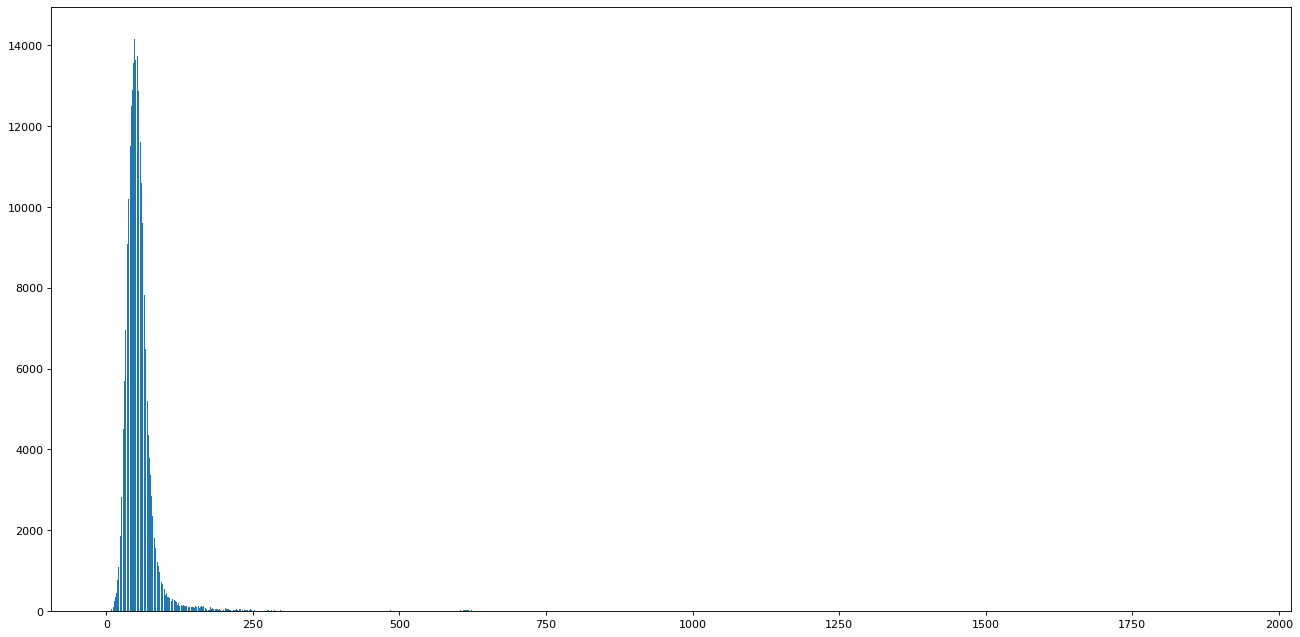

In [ ]:
lengths = []
for i in data.smiles:
    lengths.append(len(i))

c = Counter(lengths)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

In [ ]:
# remove rows with molecule SMILES length greater than max_smiles
max_smiles = 100
data.drop(data[data["smiles"].map(len) > max_smiles].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

504619

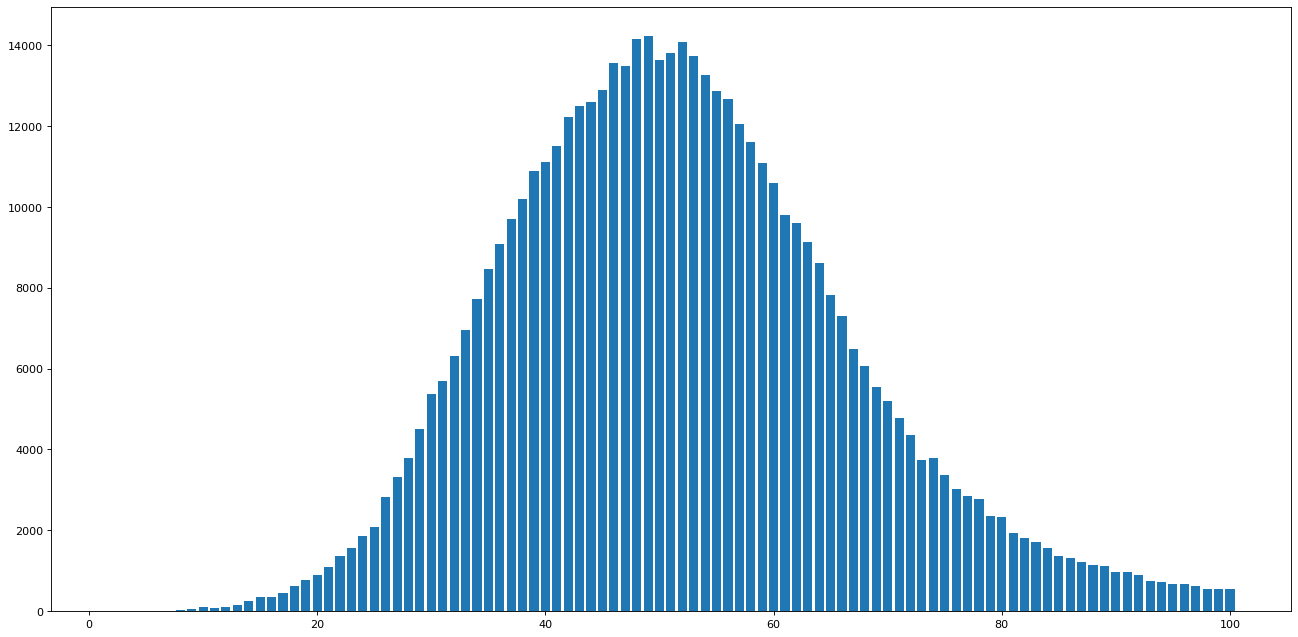

In [ ]:
lengths = []
for i in data.smiles:
    lengths.append(len(i))

c = Counter(lengths)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

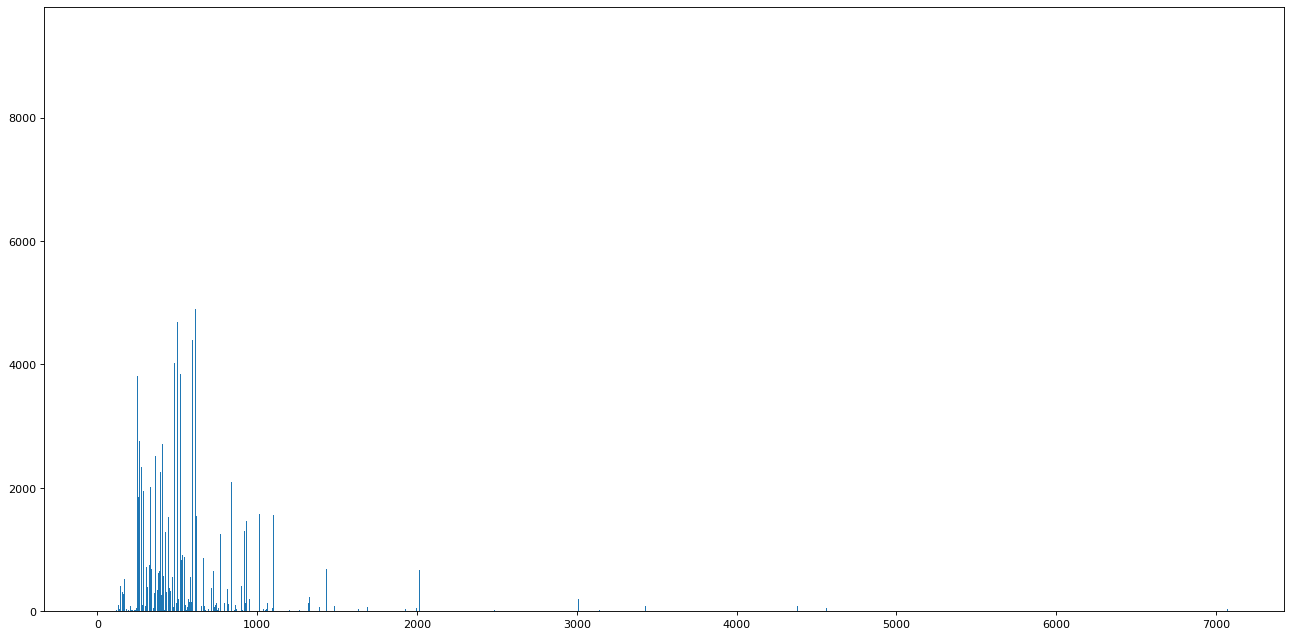

In [ ]:
lengths = []
for i in data.fasta:
    lengths.append(len(i))

c = Counter(lengths)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

In [ ]:
# remove rows with molecule SMILES length greater than max_fasta
max_fasta = 5000
data.drop(data[data["fasta"].map(len) > max_fasta].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

504542

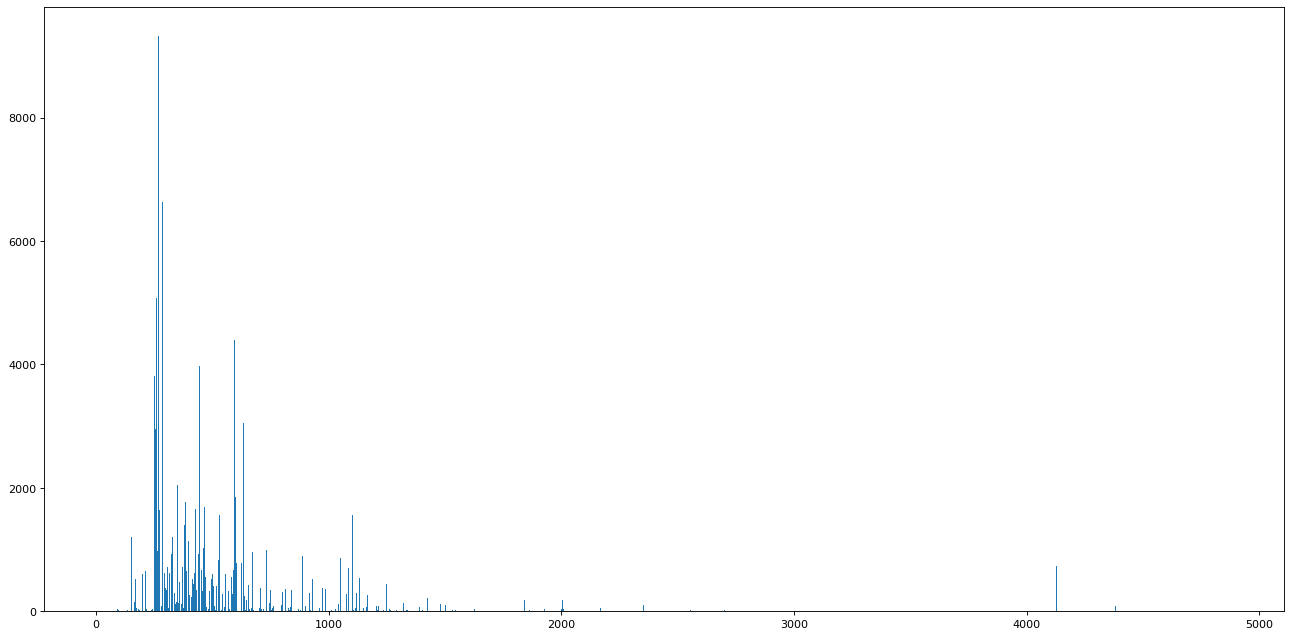

In [ ]:
lengths = []
for i in data.fasta:
    lengths.append(len(i))

c = Counter(lengths)
del lengths
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

In [ ]:
# remove negative IC50 values
data.drop(data[data["standard_value"] < 0.0].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

504528

In [ ]:
# remove IC50 values over 1,000,000
data.drop(data[data["standard_value"] > 1000000.0].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

501577

In [ ]:
data.standard_value.describe()

count     501577.000000
mean       13465.875288
std        63477.434940
min            0.000000
25%           30.000000
50%          370.000000
75%         4350.000000
max      1000000.000000
Name: standard_value, dtype: float64

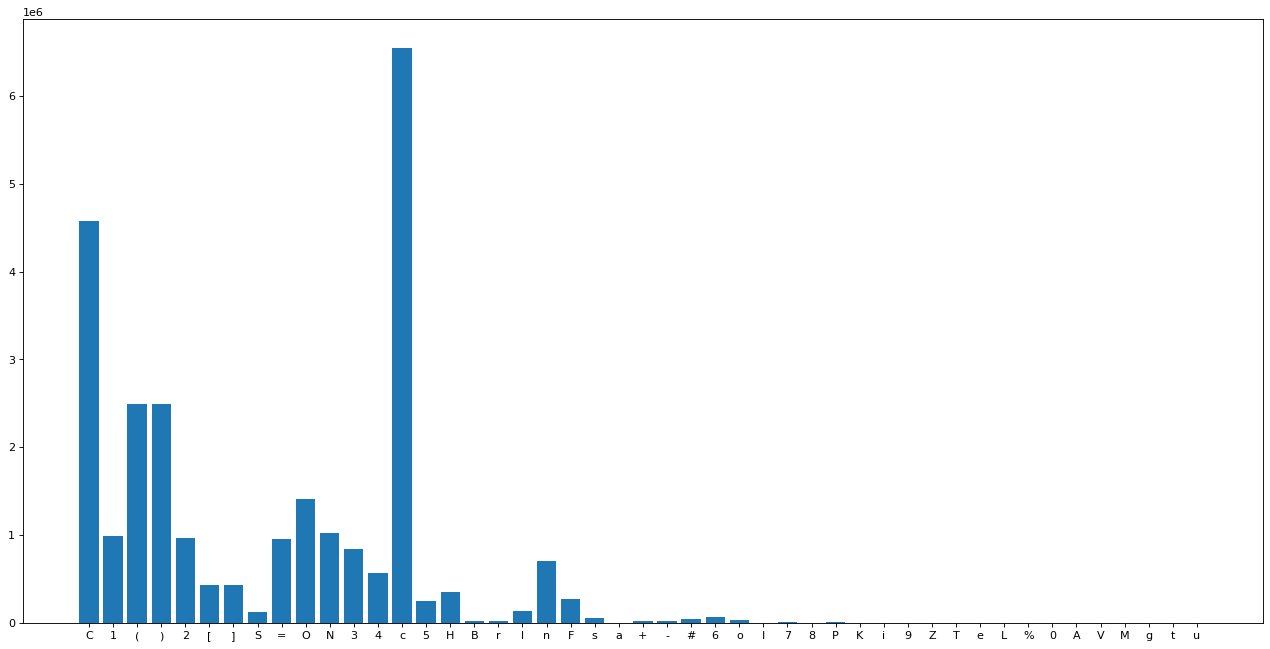

In [ ]:
# element distribution in molecules (SMILES)
chars = []
for seq in data.smiles:
    for char in seq:
        chars.append(char)
c = Counter(chars)
del chars
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

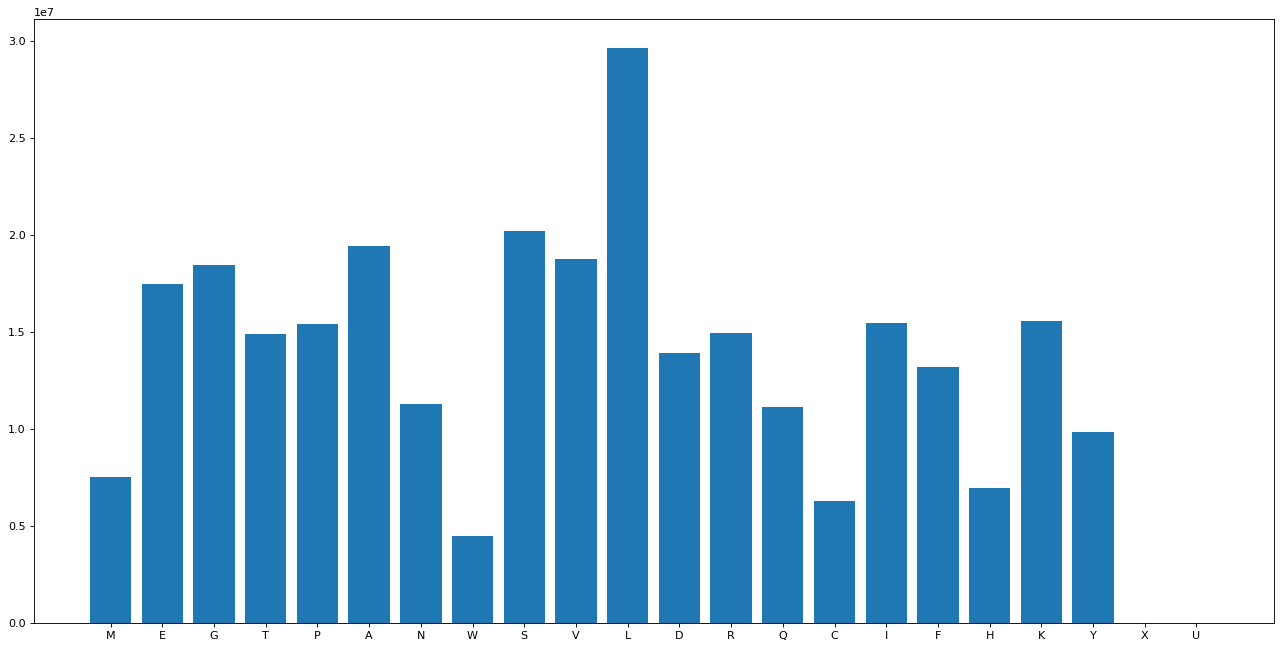

In [ ]:
# amino acid distribution in protein sequences
letters = []
for seq in data.fasta:
    for letter in seq:
        letters.append(letter)
c = Counter(letters)
del letters
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

## Split Train/Valid Sets

In [ ]:
# shuffle rows
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,smiles,fasta,standard_value
0,CNCc1ccc(cc1)n2cc3c(F)c(F)cc(C(=O)N)c3n2,MAESSDKLYRVEYAKSGRASCKKCSESIPKDSLRMAIMVQSPMFDG...,25.0
1,O=C(CNC12CC3CC(CC(C3)C1)C2)N4[CH](CC[CH]4C#N)C#N,MKTPWKVLLGLLGAAALVTIITVPVVLLNKGTDDATADSRKTYTLT...,106.0
2,COC(=O)c1ccsc1C=C2Oc3ccc(O)c(OC)c3c4ccc5NC(C)(...,MDSKESLTPGREENPSSVLAQERGDVMDFYKTLRGGATVKVSASSP...,1.8
3,COc1cccc(c1)c2cc(O)c3cccnc3n2,MREIVHIQAGQCGNQIGAKFWEVISDEHGIDPTGSYHGDSDLQLER...,960.0
4,CCOC(=O)CCCCCCn1c(C)nc(c2ccc(F)cc2)c1c3ccc(F)cc3,MVQYELWAALPGASGVALACCFVAAAVALRWSGRRTARGAVVRARQ...,64.0


In [ ]:
num_train = 500000
batch_siz = 50000
train_all = data[:num_train]
valid = data[num_train:]
del data
print('Num Training Samples:', len(train_all))
print('Num Validation Samples:', len(valid))

Num Training Samples: 500000
Num Validation Samples: 1577


In [ ]:
print("Train Proteins:", len(train_all.fasta.unique()))
print("Train Ligands:", len(train_all.smiles.unique()), "\n")

valid_proteins = len(valid.fasta.unique())
valid_ligands = len(valid.smiles.unique())
print("Valid Proteins:", valid_proteins)
print("Valid Ligands:", valid_ligands)

Train Proteins: 3813
Train Ligands: 323701 

Valid Proteins: 699
Valid Ligands: 1573


In [ ]:
shared_proteins = len(set(train_all.fasta) & set(valid.fasta))
shared_ligands = len(set(train_all.smiles) & set(valid.smiles))
print(shared_proteins, "Proteins Shared Over Train and Valid Sets")
print(shared_ligands, "Ligands Shared Over Train and Valid Sets")

699 Proteins Shared Over Train and Valid Sets
843 Ligands Shared Over Train and Valid Sets


In [ ]:
print("Valid Set Contains", valid_proteins-shared_proteins, "New Proteins")
print("Valid Set Contains", valid_ligands-shared_ligands, "New Ligands")

Valid Set Contains 0 New Proteins
Valid Set Contains 730 New Ligands


## Make Validation Data

In [ ]:
list_smiles_elements = ['6', '3', '=', 'H', 'C', 'O', 'c', '#', 'a', '[', 't', 'r', 'K', 'n', 'B', 'F', '4', '+', ']', '-', '1', 'P', '0', 'L', '%', 'g', '9', 'Z', '(', 'N', '8', 'I', '7', '5', 'l', ')', 'A', 'e', 'o', 'V', 's', 'S', '2', 'M', 'T', 'u', 'i']
smiles_to_int = dict(zip(list_smiles_elements, range(1, len(list_smiles_elements)+1)))
elements = len(list_smiles_elements) + 1 # added one for empty characters filled in with 0's

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
amino_to_int = dict(zip(amino_acids, range(1, len(amino_acids)+1)))
aminos = len(amino_acids) + 1 # added one for empty characters filled in with 0's

In [ ]:
def get_data(data):

    smiles = []
    for seq in data.smiles:
        factorized_seq_list = []
        for element in seq:
            factorized_seq_list.append(smiles_to_int[element])
        while(len(factorized_seq_list)!=max_smiles): # longest molecule
            factorized_seq_list.append(0) # pad with zeros
        smiles.append(factorized_seq_list)

    fastas = []
    for seq in data.fasta:
        factorized_seq_list = []
        for amino in seq:
            factorized_seq_list.append(amino_to_int[amino])
        while(len(factorized_seq_list)!=max_fasta): # longest protein
            factorized_seq_list.append(0) # pad with zeros
        fastas.append(factorized_seq_list)

    labels = list(data.standard_value)

    return smiles, fastas, labels

In [ ]:
x_valid_smiles, x_valid_fasta, y_valid = get_data(valid)

print(x_valid_smiles[0])
print(x_valid_fasta[0])
print(y_valid[0])

[30, 5, 5, 5, 5, 10, 5, 4, 19, 29, 6, 22, 29, 3, 6, 36, 29, 6, 36, 5, 5, 5, 5, 5, 21, 5, 5, 5, 5, 5, 21, 36, 5, 29, 3, 6, 36, 30, 43, 5, 5, 5, 10, 5, 4, 19, 43, 5, 29, 3, 6, 36, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 6, 1, 1, 13, 6, 15, 15, 6, 13, 15, 10, 10, 15, 13, 13, 13, 13, 10, 10, 10, 10, 10, 10, 10, 10, 15, 13, 13, 13, 1, 1, 10, 17, 10, 3, 13, 6, 10, 10, 13, 6, 3, 5, 1, 1, 3, 4, 1, 6, 1, 15, 10, 5, 1, 16, 16, 22, 12, 16, 16, 1, 4, 14, 19, 10, 5, 15, 16, 17, 1, 1, 16, 20, 1, 7, 3, 17, 12, 8, 17, 1, 4, 12, 1, 15, 15, 14, 4, 4, 4, 1, 10, 10, 16, 14, 4, 5, 1, 4, 1, 20, 6, 9, 9, 1, 9, 4, 10, 22, 3, 13, 19, 20, 14, 12, 5, 17, 3, 13, 4, 10, 15, 15, 8, 8, 6, 1, 19, 15, 17, 10, 6, 13, 1, 12, 10, 13, 10, 1, 9, 15, 14, 14, 22, 12, 16, 10, 10, 16, 12, 11, 16, 14, 8, 22, 16, 17, 6, 9, 19, 2, 5, 13, 12, 9, 17, 1, 16, 2, 20, 16, 10, 3, 13, 3, 10, 12, 12, 8, 10, 1, 16, 16, 15, 16, 22, 1

## Model

In [ ]:
# 1D CNN model

smiles_input = layers.Input(shape=(max_smiles,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = layers.Embedding(output_dim=128, input_dim=elements, input_length=max_smiles)(smiles_input) 

# use 1-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_smiles = layers.Conv1D(filters=32, kernel_size=3, padding='SAME', input_shape=(batch_siz, max_smiles))(embed_smiles)
activation1_smiles = layers.PReLU()(conv1_smiles)
conv2_smiles = layers.Conv1D(filters=64, kernel_size=3, padding='SAME')(activation1_smiles)
activation2_smiles = layers.PReLU()(conv2_smiles)
conv3_smiles = layers.Conv1D(filters=128, kernel_size=3, padding='SAME')(activation2_smiles)
activation3_smiles = layers.PReLU()(conv3_smiles)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_smiles = layers.GlobalMaxPooling1D()(activation3_smiles)

fasta_input = layers.Input(shape=(max_fasta,), dtype='int32', name='fasta_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_fasta = layers.Embedding(output_dim=256, input_dim=aminos, input_length=max_fasta)(fasta_input)

# use 1-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_fasta = layers.Conv1D(filters=32, kernel_size=3, padding='SAME', input_shape=(batch_siz, max_fasta))(embed_fasta)
activation1_fasta = layers.PReLU()(conv1_fasta)
conv2_fasta = layers.Conv1D(filters=64, kernel_size=3, padding='SAME')(activation1_fasta)
activation2_fasta = layers.PReLU()(conv2_fasta)
conv3_fasta = layers.Conv1D(filters=128, kernel_size=3, padding='SAME')(activation2_fasta)
activation3_fasta = layers.PReLU()(conv3_fasta)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_fasta = layers.GlobalMaxPooling1D()(activation3_fasta)

# merge both smiles and fasta
concat_pools = layers.concatenate([global_pool_smiles, global_pool_fasta])

# dense layers 
dense1 = layers.Dense(1024, activation='relu')(concat_pools)
dropout1_dense = layers.Dropout(0.1)(dense1)
dense2 = layers.Dense(512, activation='relu')(dropout1_dense)

# output
output = layers.Dense(1, name='output', activation="relu", kernel_initializer="normal")(dense2) # relu range (0, inf) --> matches labels because the data only contains positive IC50 values

model = Model(inputs=[smiles_input, fasta_input], outputs=[output])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
smiles_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
fasta_input (InputLayer)        [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 128)     6144        smiles_input[0][0]               
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 5000, 256)    5888        fasta_input[0][0]                
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
# loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

# accuracy metric
def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1-SS_res/(SS_tot)+K.epsilon())

# compile model
model.compile(optimizer = 'adam', 
              loss = {'output': 'mae'}, # 'mse', 'mae', root_mean_squared_error
              metrics = {'output': r2_score}) 

## Callbacks

In [ ]:
# checkpointer
save_model_path = "affinity-best.hdf5"
checkpoint = ModelCheckpoint(save_model_path, 
                             monitor='val_loss', 
                             verbose=1,        
                             save_best_only=True)

## Train on Batches

In [ ]:
epochs = 100

for epoch in range(epochs):

    print("\nStarting Epoch", epoch+1, "\n")

    train_index_start = 0
    train_index_end = batch_siz
    while train_index_end < num_train:

        x_train_smiles, x_train_fasta, y_train = get_data(train_all[train_index_start:train_index_end])

        # fit model
        model.fit({'smiles_input': np.array(x_train_smiles), 
                   'fasta_input': np.array(x_train_fasta)},
                  {'output': np.array(y_train)},
                  validation_data=({'smiles_input': np.array(x_valid_smiles), 
                                    'fasta_input': np.array(x_valid_fasta)},
                  {'output': np.array(y_valid)}),
                  callbacks=[checkpoint],
                  epochs=1, 
                  batch_size=64)
        
        train_index_start += batch_siz
        train_index_end += batch_siz

In [ ]:
files.download(save_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Make Predictions

In [ ]:
model.load_weights(save_model_path)

In [ ]:
def predict_affinity(smiles, fasta):

    smiles_in = []
    for element in smiles:
        smiles_in.append(smiles_to_int[element])
    while(len(smiles_in)!=max_smiles): 
        smiles_in.append(0)

    fasta_in = []
    for amino in fasta:
        fasta_in.append(amino_to_int[amino])
    while(len(fasta_in)!=max_fasta): 
        fasta_in.append(0)

    return model.predict({'smiles_input': np.array(smiles_in).reshape(1, max_smiles,), 
                          'fasta_input': np.array(fasta_in).reshape(1, max_fasta,)})[0][0]

In [ ]:
idx = 0
compound = valid.iloc[idx].smiles
protein = valid.iloc[idx].fasta
print(compound)
print(protein)
print(predict_affinity(compound, protein))
print(valid.iloc[idx].standard_value)